# The HFM library - A fast marching solver with adaptive stencils 

## Part : Algorithmic enhancements to the fast marching method
## Chapter : Sensitivity analysis

The present notebook is devoted to forward and reverse differentiation of the fast marching algorithm. We limit ourselves to isotropic fast marching, but more complex models are supported equally well, see the subsequent notebooks as well as the publication :

* Jean-Marie Mirebeau and Johann Dreo, “Automatic differentiation of non-holonomic fast marching for computing most threatening trajectories under sensors surveillance,” Geometrical Science of Information conference, 2017. [link](https://hal.archives-ouvertes.fr/hal-01503607)

**Limitations.** For the purposes of sensitivity analysis, we do avoid some enhancements of the fast marching method :
* Second order enhancement of the numerical scheme. (Obtained by setting hfmInput['order']=2)
* Time dependent speed functions.

Indeed, if they were used, in the current implementation, then minor inaccuracies could arise in the the computed sensitivities.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Setting up the problem](#1.-Setting-up-the-problem)
  * [2. Forward differentiation](#2.-Forward-differentiation)
    * [2.1 Raw arguments](#2.1-Raw-arguments)
    * [2.2 Using automatic differentiation](#2.2-Using-automatic-differentiation)
  * [3. Reverse differentiation](#3.-Reverse-differentiation)
    * [3.1 Raw arguments](#3.1-Raw-arguments)
    * [3.1 Using automatic differentiation](#3.1-Using-automatic-differentiation)
    * [3.2 Caching data](#3.2-Caching-data)
  * [4. Gradient of the value function](#4.-Gradient-of-the-value-function)
    * [4.1 Relation with the geodesic flow](#4.1-Relation-with-the-geodesic-flow)
    * [4.2 Centered and upwind scheme](#4.2-Centered-and-upwind-scheme)
    * [4.3 Forward differentiation](#4.3-Forward-differentiation)
    * [4.4 Reverse differentiation](#4.4-Reverse-differentiation)
  * [5. An optimization problem : finding the cost function which maximizes distance](#5.-An-optimization-problem-:-finding-the-cost-function-which-maximizes-distance)
  * [6. Sensitivity at multiple points, possibly weighted](#6.-Sensitivity-at-multiple-points,-possibly-weighted)
    * [6.1 Raw arguments](#6.1-Raw-arguments)
    * [6.2 Using automatic differentiation](#6.2-Using-automatic-differentiation)
  * [7. Sensitivity to multiple parameters](#7.-Sensitivity-to-multiple-parameters)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [2]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Sensitivity','FMM'))

In [2]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import FiniteDifferences as fd
from agd import Metrics
from agd.Plotting import savefig; #savefig.dirName = 'Figures/Sensitivity'
norm_infinity = ad.Optimization.norm_infinity

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize

In [4]:
def reload_packages():
    from importlib import reload
    HFMUtils = reload(sys.modules['agd.HFMUtils'])
    HFMUtils.reload_submodules()
    fd = reload(sys.modules['agd.FiniteDifferences'])
    Metrics = reload(sys.modules['agd.Metrics'])
    Metrics.reload_submodules()
    ad = reload(sys.modules['agd.AutomaticDifferentiation'])
    ad.reload_submodules()

## 1. Setting up the problem

We choose as a start to set up a same problem as considered in the [first notebook](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A1_Isotropic.ipynb): a path planning problem involving an isotropic cost, on a two dimensional domain with obstacles.
More precisely, we compute the unique viscosity solution $u: \overline \Omega \to ]-\infty,\infty]$ to an eikonal equation
\begin{align*}
\forall x \in \Omega, \|\nabla u(x)\| &= c(x), &
\forall x \in \partial \Omega, u(x) &= \sigma(x).
\end{align*}
This PDE solution is known to solve the following optimal control problem
\begin{equation*}
    u(x) = \min_{\substack{\gamma(0) \in \partial \Omega\\ \gamma(1)=x}} \sigma(\gamma(0))+ \int_0^1 c(\gamma(t)), \|\gamma'(t)\| \,\mathrm dt
\end{equation*}
and the minimal paths $\gamma:[0,1] \to \overline \Omega$ can be efficiently backtracked.

**Choice of the numerical scheme.** At this point, we need to mention that there exists two consistent discretizations of the eikonal equation, namely:
$$
    \|\nabla u(x)\|^2 
    \approx h^{-2} \sum_{1\leq i \leq d} \max \{0,u(x)-u(x-h e_i), u(x)-u(x+h e_i)\}^2, 
$$
and 
$$
    \|\nabla u(x)\|^2 
    \approx h^{-2} \sum_{1\leq i \leq d} \sum_{s \in \{-1,1\}} \max \{0,u(x)-u(x- h s e_i)\}^2,
$$
where $h$ denotes the gridscale, and $(e_1,\cdots,e_d)$ is the canonical basis of $\mathbb R^d$.

* The first implementation (left), referred to as 'Isotropic2', is usually preferred since it is more accurate at points were the solution $u$ looses differentiability, e.g. near the cut locus (the points reached by two minimal geodesics). 

* The second implementation, referred to as 'IsotropicDiff2', has the advantage of being continuously differentiable w.r.t. the values of $u$, and is thus better behaved when it comes to automatic differentiation.

In [5]:
hfmInput = {}
hfmInput['model']='Isotropic2' # Alternatively 'IsotropicDiff2'

Before turning to sensitivity analysis, let us recall how the software is run and its output displayed.

In [6]:
hfmInput['arrayOrdering']='RowMajor'

# Define the domain
hfmInput.update(
    HFMUtils.Rect(sides=[[-1,1],[0,1]],gridScale=1./100.)
)

# Set up the boundary conditions
hfmInput['seeds']=[[-0.5,0.3],[0.5,0.8]] # Seed position
hfmInput['seedValues']=[0.,0.5] # Boundary condition imposed at the seed. Defaults to $[0.,0.]$.

# Define the speed function
X,Y = HFMUtils.GetGrid(hfmInput) # Create a coordinate system
hfmInput['cost'] = np.exp(-0.5*(X**2+Y**2)) # Define the cost function

# Insert the obstacles
disk = (X-0.3)**2 + (Y-0.3)**2 <= 0.2**2
barrier = np.logical_and(X==X[70,0], Y>=0.4)
walls = np.logical_or(disk,barrier) 
hfmInput['walls']= walls

# Request the desired outputs
hfmInput['exportValues']=1. # Ask for the PDE solution
hfmInput['tips'] = [[0.,0.6],[-0.9,0.5],[0.8,0.8]] # Ask for the geodesics from these three points

In [7]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.00499 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


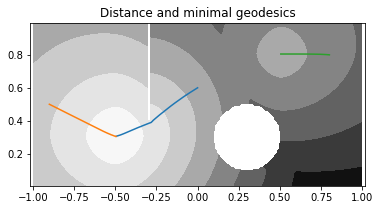

In [8]:
plt.figure(figsize=[6,3]); plt.title('Distance and minimal geodesics'); plt.axis('equal'); 
for geo in HFMUtils.GetGeodesics(hfmOutput): plt.plot(geo[:,0],geo[:,1]) 
plt.contourf(X,Y,hfmOutput['values'],cmap='Greys');

## 2. Forward differentiation



In this section, we differentiate the front arrival times $u : \Omega \to ]-\infty,\infty[$ w.r.t variations in the cost function $c : \Omega \to ]0,\infty[$, and in the boundary conditions $\sigma : \Omega\to ]-\infty,\infty[$.
More precisely, denote by $u[c,\sigma] : \Omega \to ]-\infty,\infty[$, the solution to the eikonal equation
\begin{align*}
    \forall x \in \Omega, \| \nabla u[c,\sigma](x) \| &= c(x) &
    \forall x \in \partial \Omega, u[c,\sigma](x) &= \sigma(x).
\end{align*}

Consider perturbation fields $\xi : \Omega \to \mathbb R$ and $\zeta : \partial \Omega \to \mathbb R$. Forward differentiation allows to compute the first term  $\nu : \Omega \to \mathbb R$ in the Taylor expansion of the distance function, if it exists. In other words
\begin{equation*}
\mu(x) := \frac d {d \varepsilon} u[c+ \varepsilon \xi, \sigma+ \varepsilon \zeta] (x)
\end{equation*}

These features are implemented in the HFM library, and can be accessed in two ways:
- raw arguments, where the perturbation fields $\xi$, $\zeta$ and $\mu$ discussed above are directly manipulated (under different names).
- interface with the AutomaticDifferentiation module of the agd library.

The first approach is more explicit and possibly pedagogical, yet the second approach is expected to be more convenient in practice.

### 2.1 Raw arguments

We show how the perturbation to the cost function, and to the seed values, can be provided to the HFM library by raw explicit arguments.

In [9]:
cost = hfmInput['cost']
seedValues = hfmInput['seedValues']

# Define the cost perturbation(s), above named xi. We actually define three perturbations, 
# xi_0 (on the right side of the domain only), xi_1 (on the left side only), and xi_2 (no perturbation)
hfmInput['costVariation']= np.stack([(X>0.)*cost, (X<=0.)*cost, 0.*X],2) 

# Define the boundary condition perturbation(s), above named zeta. 
# Again, similarly define three perturbation, zeta_0 (no perturbation), zeta_1 (no perturbation), and zeta_2.
hfmInput['seedValueVariation']= [[0,0],[0,0],seedValues]

In [10]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.005008 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


The following cell shows the effect $\mu_0$ of the first perturbation $(\xi_0,\zeta_0)$. Since $\xi_0$ is positive in the right side of the domain $\{x>0\}$, the perturbation increases the cost function there, hence also the value function. Therefore $\mu_0>0$ where $\{x>0\}$, as can be observed numerically. On the other hand $\zeta_0=0$, which means that boundary conditions, in other words the seed values, are untouched.

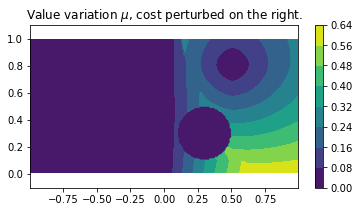

In [11]:
plt.figure(figsize=[6,3]); plt.title(r'Value variation $\mu$, cost perturbed on the right.'); plt.axis('equal'); 
# The field 'valueVariation' is denoted mu in the above mathematical expression.
plt.contourf(X,Y,hfmOutput['valueVariation'][:,:,0]) 
plt.axis('equal');plt.colorbar();

The following cell shows the effect $\mu_1$ of the second perturbation $(\xi_1,\zeta_1)$. Since $\xi_1$ is positive on the left side of the domain $\{x\leq 0\}$, the perturbation increases the cost function there, hence also the value function $u$. Therefore $\mu_1>0$ where $\{x \leq 0\}$, as can be observed numerically.

However, one can note that $\mu_1>0$ on part of the right side of the domain $\{x>0\}$ as well. That is because the corresponding minimal paths come from the left part of the domain, hence they see their cost increased by the perturbation.

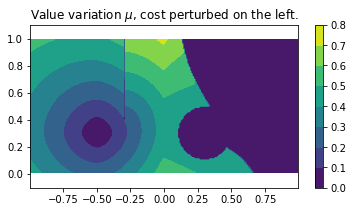

In [12]:
fig = plt.figure(figsize=[6,3]); plt.title(r'Value variation $\mu$, cost perturbed on the left.'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['valueVariation'][:,:,1])
plt.axis('equal');plt.colorbar();
savefig(fig,'ValueVariation_CostPerturbationLeft.png')

The third perturbation affects the boundary conditions only: $\xi_2=0$ and $\zeta_2 \neq 0$. More precisely, the perturbation increases the boundary condition at the right seed $x_1$ only. Therefore, as can be observed numerically, hence the value function $u$ increases in the Voronoi region of $x_1$ only. In other words $\mu_2>0$ at at all the points for which the backtracked geodesic leads to $x_1$.

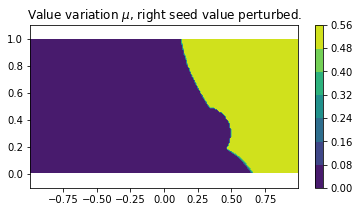

In [13]:
fig = plt.figure(figsize=[6,3]); plt.title(r'Value variation $\mu$, right seed value perturbed.'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['valueVariation'][:,:,2])
plt.axis('equal');plt.colorbar();
savefig(fig,'ValueVariation_SeedValuePerturbationRight.png')

We end this section with a consistency test, based on a mathematical property that we describe below.

It is worth noting that the arrival time function $u$ is $1$-homogeneous w.r.t. its parameters $c$ and $\sigma$
\begin{equation*}
u[\lambda c,\lambda \sigma] = \lambda u[c,\sigma].
\end{equation*}
This implies a differential identity, referred to as Euler identity for homogeneous functions:
\begin{equation*} 
    \frac d {d\lambda} u[\lambda c,\lambda \sigma] = u[c,\sigma].
\end{equation*}
In the test case above, we have chosen the perturbations such that $\xi_0+\xi_1+\xi_2 = c$ and $\zeta_0+\zeta_1+\zeta_2 = \sigma$. Thus denoting by $\mu_0,\mu_1,\mu_2$ the corresponding value variations, Euler's identity implies that $\mu_0+\mu_1+\mu_2 = u$, as can be observed numerically.

In [14]:
values = hfmOutput['values']; 
values[hfmInput['walls']]=0.; # Eliminate values inside walls, which equal Infinity

# Check Euler's identity
assert np.max(np.abs(hfmOutput['valueVariation'][:,:,0]+hfmOutput['valueVariation'][:,:,1]
                     +hfmOutput['valueVariation'][:,:,2]-values)) < 1e-14

### 2.2 Using automatic differentiation

For convenience, we provide a (limited) interface between HFM library and the AutomaticDifferentiation (ad) module of the AdaptiveGridDiscretizations (agd) package.
In that setting, some of the keys of the hfmInput dictionary can be provided as *first order dense AD* variables.
Under the hood, a pre-processing and a post-processing step reformat the AD data as in the previous subsection.
<!---In a pre-processing , the AD information will be separated and before the call to the HFM library, and then --->

In [15]:
# The following keys cannot be enhanced with AD information
hfmIn_ad = HFMUtils.dictIn({key:hfmInput[key] for key in 
            ['model','arrayOrdering','gridScale','dims','origin','seeds','walls','exportValues']})

Let us construct a first order symbolic perturbation with three independent components. 

In [16]:
delta = ad.Dense.identity(shape=(3,))

We can define a cost and seed values which incorporate first order perturbations. Here we simply reproduce the previous ones.

In [17]:
hfmIn_ad['cost'] = cost*(1+ delta[0]*(X>0.) + delta[1]*(X<=0.))
hfmIn_ad['seedValues'] = seedValues * (1+ delta[2])

A smart run will pre-process and post-process the HFM data to correct formatting.

In [18]:
hfmOut_ad = hfmIn_ad.RunSmart()

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.004869 s.
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


The field of values output by the smart run incorporates first order AD information.

In [19]:
values_ad = hfmOut_ad['values']
grad = values_ad.gradient()

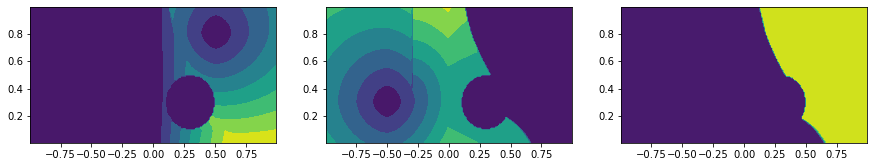

In [20]:
fig = plt.figure(figsize=[15,2.5])
plt.subplot(1,3,1)
plt.contourf(X,Y,grad[0])
plt.subplot(1,3,2)
plt.contourf(X,Y,grad[1])
plt.subplot(1,3,3)
plt.contourf(X,Y,grad[2]);

## 3. Reverse differentiation

Consider a cost function $c : \Omega \to ]0,\infty[$ and some boundary values $\sigma : \Omega \to ]-\infty,\infty]$. Reverse differentiation, for a given point $x\in \Omega$ provides two fields $\rho = \rho[x,c,\sigma] : \Omega \to \mathbb R$ and $\pi = \pi[x,c,\sigma] : \partial \Omega \to \mathbb R$ such that 
\begin{equation*}
u[c+\varepsilon \xi,\sigma+\varepsilon \zeta](x) = u[x,\sigma](x)+ \varepsilon \Bigg(\int_\Omega \rho \xi + \int_{\partial \Omega} \pi \zeta\Bigg) + o(\varepsilon).
\end{equation*}
This equality holds, assuming differentiability, for any perturbation $\xi$ of the cost function $c$, and any perturbation $\zeta$ of the boundary condition $\sigma$.
The fields $\rho$ and $\pi$ express how much the front arrival time value $u[c,\sigma]$ is sensitive to variations in these parameters.


Similarly to the forward case, this functionality can be accessed in two ways:
- by directly manipulating the perturbations fields $\xi$, $\zeta$, $\rho$, and $\pi$, suitably renamed.
- using an interface with the AutomaticDifferentiation module of the AdaptiveGridDiscretizations library.

Again, the first usage is more explicit and possibly pedagogical, but the second one is expected to be much more convenient.

### 3.1 Raw arguments

In [21]:
hfmInput['inspectSensitivity']=[ [-0.8,0.8], [0.575,0.1] ] # Ask for rho and pi related to these two points

In [22]:
hfmOutput = HFMUtils.Run(hfmInput)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.005409 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


As can illustrated in the next cell, the sensitivity $\rho = \rho[x,c,\sigma]$, of the value function $u(x)$ at a given point $x$ w.r.t. variations in the cost $c$, is (mostly) supported in the neighborhood of the minimal geodesic from $x$ to the nearest seed point. This property is actually at the foundation of one of our backtracking methods.

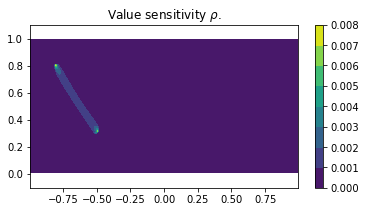

In [23]:
plt.figure(figsize=[6,3]); plt.title(r'Value sensitivity $\rho$.'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['costSensitivity_0']); # rho
plt.colorbar();

The second point $x_2 = (0.575,0.1)$ for which we request the sensitivity, is located precisely on the cut locus. In other words, it is at equal distance of the two seeds (taking into account the boundary conditions). The corresponding sensitivity $\rho$ is thus supported on the neighborhood of two geodesics.

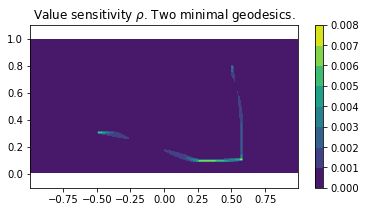

In [24]:
fig = plt.figure(figsize=[6,3]); plt.title(r'Value sensitivity $\rho$. Two minimal geodesics.'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOutput['costSensitivity_1']);
plt.axis('equal');plt.colorbar();
savefig(fig,'ValueSensitivity_TwoPaths.png')

The sensitivity of the value $u[x,c,\sigma]$ w.r.t. the boundary condition $\sigma$ is also returned, above denoted $\pi : \partial \Omega \to \mathbb R$. The format is 
\begin{equation*}
[ [s_0^0,s_0^1,\pi_0], [s_1^0,s_1^1,\pi_1], ...].
\end{equation*}
Here $s_0=(s_0^0,s_0^1)$ and $s_1=(s_1^0,s_1^1)$ are the seeds for which the corresponding sensitivity $\pi_0$ and $\pi_1$ is positive. 
If the sensitivity $u(x)$ was requested unless for a generic point $x$, then the list is of length one, and of the form $[ [s^0,s^1,1] ]$. In addition $s=(s^0,s^1)$ is the seed linked to $x$ by the minimal path.

In [25]:
hfmOutput['seedSensitivity_0']

array([[-0.495,  0.305,  1.   ]])

However, if sensitivity is requested for a point on the cut-locus, for which there exists several minimal geodesics leading to distinct seeds, then $\pi$ is supported on several seeds.

In [26]:
hfmOutput['seedSensitivity_1']

array([[ 0.505     ,  0.805     ,  0.37180042],
       [-0.495     ,  0.305     ,  0.62819958]])

A slight annoyance of the above output is that the original seeds are not returned. Instead, the returned positions correspond to the nearest point on the discretization grid. Some minor postprocessing, for instance by converting these points to multi-indices, is thus required to establish the matching.

In [27]:
hfmInput['pointToIndex'] = np.concatenate((hfmInput['seeds'],hfmOutput['seedSensitivity_1'][:,0:2]))
hfmOutput = HFMUtils.Run(hfmInput)
print("Seeds, original and nearest gridpoint :\n", hfmInput['pointToIndex'],"\n")
print("Indices :\n", hfmOutput['indexFromPoint'].astype(int))
# Note that the order of the seeds may not be preserved

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.004953 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Seeds, original and nearest gridpoint :
 [[-0.5    0.3  ]
 [ 0.5    0.8  ]
 [ 0.505  0.805]
 [-0.495  0.305]] 

Indices :
 [[ 50  30]
 [150  80]
 [150  80]
 [ 50  30]]


We conclude this section with a consistency check. More precisely, we ensure that our two automatic differentiation methods yield consistent results.
Both can be used to compute the scalar $\mu(x)$ appearing in the following Taylor expansion
\begin{equation*}
    u[c+\varepsilon \xi, \sigma+\varepsilon \zeta] (x) = u[c,\sigma](x)+\varepsilon \mu(x) + o(\varepsilon),
\end{equation*}
where the point $x$ and the perturbations $\xi$ and $\zeta$ are given.
The two differentiation methods use distinct inputs, as follows.
* Forward differentiation. *Input*: $\xi$ (costVariation), $\zeta$ (seedValueVariation). *Output*: $\mu$ (valueVariation).
* Reverse differentiation. *Input*: $x$ (inspectSensitivity). *Output*: $\rho$ (costSensitivity) and $\pi$ (seedSensitivity).

The inputs $x,\zeta,\xi$ and outputs $\mu, \rho, \pi$, are mathematically tied by the the following identity, which we verify numerically:
\begin{equation*}
\mu(x) = \int_\Omega \rho \xi + \int_{\partial \Omega} \pi \zeta.
\end{equation*}

In [28]:
# Get the grid indices index0 and index1, of the points x0 and x1 at which sensitivity was computed
hfmInput['pointToIndex'] = hfmInput['inspectSensitivity'] 
hfmOutput = HFMUtils.Run(hfmInput)
index0, index1 = hfmOutput['indexFromPoint'].astype(int)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.005036 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


In the first instance of forward differentiation, boundary conditions were not perturbed ($\zeta=0$). Hence we expect, and numerically check, that $\mu(x) = \int_\Omega \rho \xi$.

In [29]:
mu_x = hfmOutput['valueVariation'][index1[0],index1[1],0] # Evaluates mu(x)
int_dom = (hfmInput['costVariation'][:,:,0]*hfmOutput['costSensitivity_1']).sum() #  Evaluates int_Omega rho*xi 

assert abs(mu_x-int_dom) < 1e-14

In the last instance of forward differentiation, the cost function was not perturbed ($\xi=0$). Hence we expect, and numerically check, that  $\mu(x) = \int_{\partial\Omega} \pi \zeta$.

In [30]:
mu_x = hfmOutput['valueVariation'][index1[0],index1[1],2] # Evaluates mu(x)
int_bd = np.dot(hfmOutput['seedSensitivity_1'][(1,0),2] , hfmInput['seedValueVariation'][2,:]) # int_Boundary pi*zeta

assert abs(mu_x-int_bd) < 1e-14 

### 3.1 Using automatic differentiation

An interface is provided with the *reverse first order* automatic differentiation module of the agd library.

In [31]:
# These variables cannot be enhanced with automatic differentiation
hfmIn_rev = {key:hfmInput[key] for key in 
            ['model','arrayOrdering','gridScale','dims','origin','seeds','walls']}

We need to register the variables w.r.t which sensitivity will be requested.

In [32]:
rev,(cost_rev,seedValues_rev) = ad.Reverse.empty(inputs=(cost,seedValues),input_iterables=(tuple,dict,))

**Note on the `input_iterables` field.** By default, the ad.Reverse automatic differentiation module only looks for AD information inside tuples. This behavior is here modified, through the `input_iterables` field, since calls to the HFM library involve a dictionary of inputs. See the notebook [Reverse](../Notebooks_Algo/Reverse.ipynb) for details.

In [33]:
hfmIn_rev['cost'] = cost_rev
hfmIn_rev['seedValues'] = seedValues_rev

In order to be taken into account, the solution values will be returned separately from the rest of the HFM outputs. 
This is achieved with the `extractValues` key.

<!---
*Note on the `output_iterables` field.* Another approach would be to instruct the reverse AD method to look into output dictionaries. However, doing so would mean tagging all the output variables with AD information (including CPU times, etc)--->

In [34]:
hfmIn_rev['extractValues']=True

In [35]:
hfmOut,values_rev = rev.apply(HFMUtils.Run,hfmIn_rev,smart=True)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.005056 s.
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


Let us define the objective function, which has to be a scalar function, in terms of the values.

In [36]:
grid = np.array((X,Y))
values_rev_interp = fd.UniformGridInterpolator(grid,values_rev)

points = np.array([[-0.8,0.8],[0.575,0.1]]).T
val = values_rev_interp(*points)

objective = 2*val[0]**2+val[1]**2 

In [37]:
grad = rev.gradient(objective)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.004935 s.
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


In [38]:
cost_sensitivity,seed_sensitivity = rev.to_inputshapes(grad)

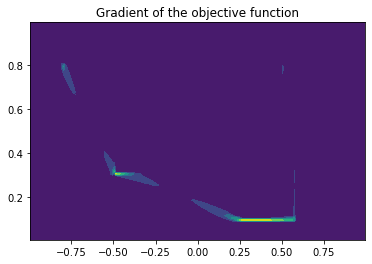

In [39]:
plt.title('Gradient of the objective function')
plt.contourf(*grid,cost_sensitivity);

In [40]:
seed_sensitivity

array([3.29170665, 0.42199756])

### 3.2 Caching data

Reverse automatic differentiation is a two pass procedure:
- The function *value* is evaluated in an initial *forward* pass.
- The function *jacobian*, transposed, is applied to a suitable co-vector in a final *backward* pass.

If suitable data is cached in the first pass, then the jacobian evaluation in the second pass can avoid the full recomputation of the function value.
Compare the results above and below.

In [41]:
hfmIn_rev = {key:hfmInput[key] for key in 
            ['model','arrayOrdering','gridScale','dims','origin','seeds','walls','seedValues']}
hfmIn_rev['extractValues']=True

For a change, in contrast with the previous paragraph, we do not register the seed values for automatic differentiation.

In [42]:
rev,cost_rev = ad.Reverse.empty(inputs=cost,input_iterables=(dict,))
hfmIn_rev['cost'] = cost_rev

In [43]:
cache = HFMUtils.Cache()
hfmOut,values_rev = rev.apply(HFMUtils.RunSmart,hfmIn_rev,cache=cache)

Requesting cacheable data
Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.005087 s.
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Filling cache data


Some output data is cached so as to bypass most the fast marching solver in future computations on this data.

In [44]:
cache.contents.keys()

dict_keys(['values', 'activeNeighs'])

We next define the objective function, and compute its sensitivity w.r.t. the cost function.

In [45]:
values_rev_interp = fd.UniformGridInterpolator(grid,values_rev)
val = values_rev_interp(*points)
objective = 2*val[0]**2+val[1]**2 

In [46]:
cost_sensitivity_cache, = rev.to_inputshapes(rev.gradient(objective))

Providing cached data
Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Bypassing fast marching solver based on cached data.
Field exportActiveOffsets defaults to 0


As mentioned in the last line, and in contrast with the previous subsection, the fast marching solver was bypassed entirely in the reverse pass thanks to the cached data. Yet the result is identical.

In [47]:
assert norm_infinity(cost_sensitivity-cost_sensitivity_cache,axis=None)==0.

## 4. Gradient of the value function

We discuss the computation of the gradient of the value function, using a centered or upwind scheme.
Then we compute its first order perturbation using forward or reverse automatic differentiation.

### 4.1 Relation with the geodesic flow

Let $u : \Omega \to R$ be the value function, also referred to as the distance map, which is approximated by the fast marching algorithm. One would like to estimate the gradient $\nabla u$, which satisfies the eikonal equation
$$
    \| \nabla u(x) \| = c(x)
$$
at any $x \in \Omega$, where $c(x)$ is the cost function. A closely related quantity is the geodesic flow, which is defined by 
$$
    V(x) := \frac 1 {c(x)^2} \nabla u(x),
$$
and for which the HFM library provides an upwind approximation. 

**Note on anisotropic metric.** When metric is Riemannian or Finslerian, the gradient and the geodesic flow are not anymore proportionnal, but are related through norm duality, see the notebook [Sensitivity in Semi-Lagrangian schemes](SensitivitySL.ipynb).

In [48]:
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'arrayOrdering':'RowMajor',
    'seeds':[[-0.5,0.3],[0.5,0.8]],
    'seedValues':[0.,0.5],
    'tips':[[0.,0.6],[-0.9,0.5],[0.8,0.8]],
    'walls':np.logical_or(disk,barrier),
    'cost':np.exp(-0.5*(X**2+Y**2)),
    
    'exportValues':True,
    'exportGeodesicFlow':True,
})

hfmIn.SetRect(sides=[[-1,1],[0,1]],gridScale=1./100.)
grid = hfmIn.Grid()
h = hfmIn['gridScale']

In [49]:
hfmOut = hfmIn.RunSmart()

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.005059 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0


The gradient is easily recovered from the geodesic flow.

In [50]:
grad_hfm = hfmOut['flow']*hfmIn['cost']**2

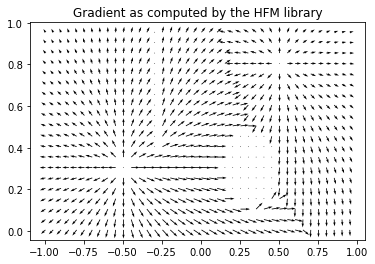

In [51]:
plt.title("Gradient as computed by the HFM library")
s=5; plt.quiver(*grid[:,::s,::s],*grad_hfm[:,::s,::s]);

### 4.2 Centered and upwind scheme

We may also directly recompute the gradient using finite differences. Centered finite differences are usually more precise, whereas upwind finite differences are usually more stable.

*Note on Python warnings.** Those come from the computation of the gradient inside obtacles, where the the value function is $+\infty$.

In [52]:
grad_centered = fd.DiffGradient(hfmOut['values'],gridScale=h)

../agd/FiniteDifferences.py:102: RuntimeWarning: invalid value encountered in add
  return sum(TakeAtOffset(u,mult*np.array(offset),**kwargs)*weight for mult,weight in zip(multiples,weights))


In [53]:
def gradient_upwind(u,h):
    """(Quasi-)Upwind gradient of an array u at gridscale h"""
    offsets = np.eye(u.ndim).astype(int)
    dup = fd.DiffUpwind(u, offsets, h, padding=np.inf)
    dum = fd.DiffUpwind(u,-offsets, h, padding=np.inf)
    return ad.where(dup<dum,dup,-dum)

In [54]:
grad_upwind = gradient_upwind(hfmOut['values'],h)

/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


The upwind and hfm gradient are actually identical up to machine precision, except inside obstacles and along lines where the scheme "degenerates" in the sense that there is only one active neighbor.

In [55]:
grad_same = np.linalg.norm(grad_upwind-grad_hfm,axis=0)<1e-12
ratio = np.logical_or(grad_same,hfmIn['walls']).sum()/grad_same.size
assert ratio>0.95
print(f"Pixel ratio where hfm and 'upwind' gradient are equal : {ratio}")

Pixel ratio where hfm and 'upwind' gradient are equal : 0.97345


/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


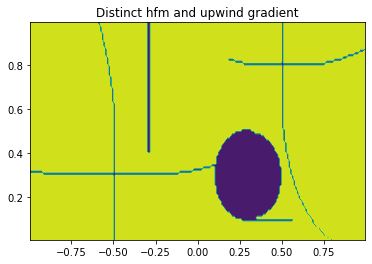

In [56]:
plt.title("Distinct hfm and upwind gradient")
plt.contourf(*grid,grad_same);

In this example, not much distinguishes the centered and the upwind gradient.

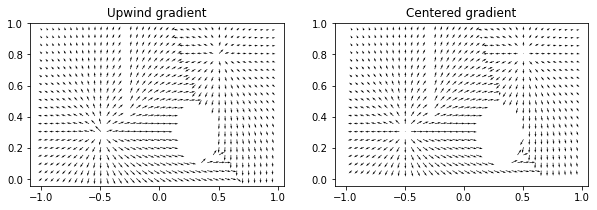

In [57]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title("Upwind gradient")
s=5; plt.quiver(*grid[:,::s,::s],*grad_upwind[:,::s,::s]);
plt.subplot(1,2,2)
plt.title("Centered gradient")
s=5; plt.quiver(*grid[:,::s,::s],*grad_centered[:,::s,::s]);

### 4.3 Forward differentiation

Finite differences are compatible with automatic differentiation. For illustration, we compute the first order perturbation of the value function gradient w.r.t. the perturbations of the cost function and seed values previously considered.

In [58]:
hfmOut = hfmIn_ad.RunSmart()

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.005053 s.
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


In [59]:
grad_upwind_ad = gradient_upwind(hfmOut['values'],h)
grad_centered_ad = fd.DiffGradient(hfmOut['values'],gridScale=h)

../agd/AutomaticDifferentiation/Dense.py:45: RuntimeWarning: invalid value encountered in add
  return denseAD(self.value+other.value, _add_coef(self.coef,other.coef))
../agd/AutomaticDifferentiation/Dense.py:192: RuntimeWarning: invalid value encountered in less
  return super(denseAD,self).__array_ufunc__(ufunc,method,*inputs_,**kwargs)


Autoatic differentiation has no impact on the zero-th order term, where it is defined.

In [60]:
assert np.all(np.logical_or(grad_upwind_ad.value==grad_upwind,np.isnan(grad_upwind)))
assert np.all(np.logical_or(grad_centered_ad.value==grad_centered,np.isnan(grad_centered)))

The improved stability of the upwind gradient, w.r.t.\ the centered gradient, is slightly more visible when differentiation is involved. One sees that the centered gradient features more long spurious arrow, originating from the vicity of obtsacles or of the boundary.

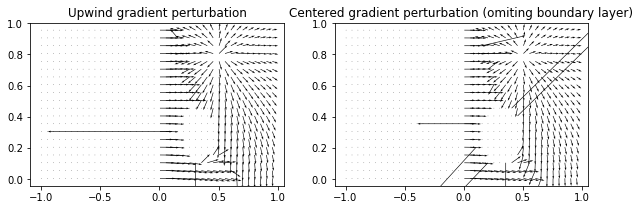

In [61]:
perturbation_index = 0
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.title("Upwind gradient perturbation")
plt.quiver(*grid[:,::s,::s],*grad_upwind_ad.gradient(perturbation_index)[:,::s,::s]);
plt.subplot(1,2,2)
plt.title("Centered gradient perturbation (omiting boundary layer)")
plt.quiver(*grid[:,::s,::s],*grad_centered_ad.gradient(perturbation_index)[:,1:-1:s,1:-1:s]);

### 4.4 Reverse differentiation

We illustrate reverse differentiation of the value function gradient

In [62]:
rev,cost_rev = ad.Reverse.empty(inputs=cost,input_iterables=(dict,))
hfmIn_rev['cost'] = cost_rev

In [63]:
hfmOut,values_rev = rev.apply(HFMUtils.RunSmart,hfmIn_rev,cache=HFMUtils.Cache())

Requesting cacheable data
Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.00487 s.
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Filling cache data


In [64]:
grad_upwind_rev = gradient_upwind(values_rev,h)
grad_centered_rev = fd.DiffGradient(values_rev,gridScale=h)

../agd/AutomaticDifferentiation/Sparse.py:49: RuntimeWarning: invalid value encountered in add
  value = self.value+other.value
../agd/AutomaticDifferentiation/Sparse.py:211: RuntimeWarning: invalid value encountered in less
  return super(spAD,self).__array_ufunc__(ufunc,method,*inputs_,**kwargs)


In [65]:
def objective(grad):
    interp = fd.UniformGridInterpolator(grid,grad)
    p0,p1 = points.T 
    # Return horizontal component at p0, vertical component at p1
    return interp(*p0)[0] +interp(*p1)[1] 

In [66]:
grad_upwind_cost, = rev.to_inputshapes(rev.gradient(objective(grad_upwind_rev)))
print("---- Finished upwind, turning to centered ----")
grad_centered_cost, = rev.to_inputshapes(rev.gradient(objective(grad_centered_rev)))

Providing cached data
Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Bypassing fast marching solver based on cached data.
Field exportActiveOffsets defaults to 0
---- Finished upwind, turning to centered ----
Providing cached data
Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Bypassing fast marching solver based on cached data.
Field exportActiveOffsets defaults to 0


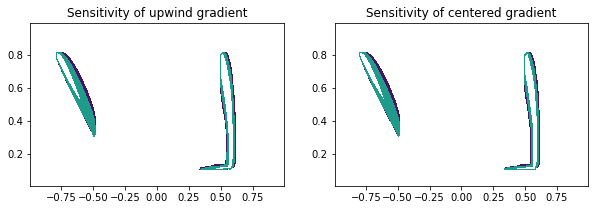

In [67]:
levels = [0.0001,0.001,0.01]
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title("Sensitivity of upwind gradient")
plt.contourf(*grid,grad_upwind_cost,levels=levels)
plt.subplot(1,2,2)
plt.title("Sensitivity of centered gradient")
plt.contourf(*grid,grad_centered_cost,levels=levels);

Validation by comparison with forward gradient. 

In [68]:
grad_diff = (grad_upwind_cost * hfmIn_ad['cost']).sum().gradient() - objective(grad_upwind_ad).gradient()
assert norm_infinity(grad_diff[:2])<1e-13
# Third component ignored because related with seedValueVariation, not considered in reverse more here.

## 5. An optimization problem : finding the cost function which maximizes distance

We illustrate automatic differentiation solving an optimization problem posed on cost functions $c$. The objective is to maximize the distance from a point $x_*$ to the boundary, minus a integral penalty on the cost. Formally, the problem reads as follows
\begin{align*}
    \max_{c : \Omega \to [\alpha,\beta]} \, u[c](x_*) - \gamma \int_\Omega c.
\end{align*}
The bounds $\alpha,\beta > 0$ imposed on the cost function, and the penalization factor $\gamma >0$ on the cost function integral, are given parameters, as well as the target point $x_*$.

Experiments of similar nature are presented in :
* F. Benmansour, G. Carlier, G. Peyré, and F. Santambrogio, “Derivatives with respect to metrics and applications: subgradient marching algorithm,” Numerische Mathematik, vol. 116, no. 3, pp. 357–381, May 2010.
* J.-M. Mirebeau and J. Dreo, “Automatic differentiation of non-holonomic fast marching for computing most threatening trajectories under sensors surveillance,” presented at the Geometrical Science of Information, 2017.

In [69]:
optInput = {}
optInput['model']='IsotropicDiff2' # Alternatively, 'Isotropic2'

In [70]:
#Fast marching parameters, copied from earlier problem, with different seed
for key in ['arrayOrdering','dims','gridScale','origin','walls']:
    optInput[key]=hfmInput[key]

# Problem parameters
alpha = 0.1; beta=1.; gamma=1.5;
optInput['seeds']=[[-0.7,0.7]] # Seed position

# For better stability, we slightly spread the target x_* on the four neighbor points
targetIndices = [[180,40],[179,40],[181,40],[180,39],[180,41]]; 
targetWeights = [0.5,0.125,0.125,0.125,0.125]
#Unspread target, commented below, yields less stable computations.
#targetIndices = [[40,180]]; targetWeights = [1]; 

# Silent the execution, since HFM will be called many times
optInput['verbosity']=0

optInput['cost']=1; optInput['indexToPoint']=targetIndices;
targetPoints = HFMUtils.Run(optInput)['pointFromIndex']

# Utilities
allOnes = np.ones(optInput['dims'].astype(int).prod())
hfmShape = optInput['dims'].astype(int)

We prepare two functions returning the objective function and its jacobian. 

This particular test application works better with the differentiable scheme 'IsotropicDiff2', although the usual discretization 'Isotropic2' is still usable.

In [72]:
def func(cost,sign=1):
    optInput['cost']=cost.reshape(hfmShape)
    optInput['exportValues']=1
    optInput.pop('inspectSensitivity',None)
    optOutput = HFMUtils.Run(optInput)
    value = sum([weight*optOutput['values'][index] for index,weight in zip(targetIndices,targetWeights)])
    return sign*(value - gamma*cost.sum()*optInput['gridScale']**2)

def func_deriv(cost,sign=1):
    optInput['cost']=cost.reshape(hfmShape)
    optInput['exportValues']=0
    
    # Request sensitivity for a weighted sum of values
    optInput['inspectSensitivity'] = targetPoints 
    optInput['inspectSensitivityWeights'] = targetWeights
    optInput['inspectSensitivityLengths'] = [len(targetWeights)]
    
    optOutput = HFMUtils.Run(optInput)
    return sign*(optOutput['costSensitivity_0'].flatten() - gamma*allOnes*optInput['gridScale']**2)

In [73]:
%%time
# Warning : takes up to a minute.
res = scipy.optimize.\
minimize(func,
         allOnes*(alpha+beta)/2., # Initial guess
         bounds=np.array((alpha*allOnes,beta*allOnes)).transpose(), # alpha <= c <= beta
         jac=func_deriv,
         args=(-1.), # Minimize instead of maximize
         method='L-BFGS-B',options={'gtol':1e-4,'maxiter':300})

CPU times: user 3.17 s, sys: 1.71 s, total: 4.88 s
Wall time: 8.43 s


The optimal strategy uses a large cost around the seed, the target, around the boundary of obstacles, ...

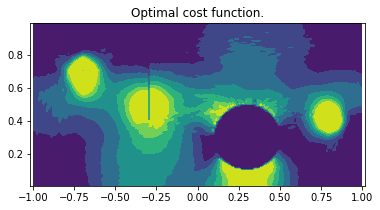

In [74]:
fig = plt.figure(figsize=[6,3]); plt.title('Optimal cost function.'); plt.axis('equal'); 
plt.contourf(X,Y,res.x.reshape(hfmShape));
savefig(fig,'OptimalCost.png')

At the optimal strategy, there is a continuum of optimal curves, spread all over the domain.

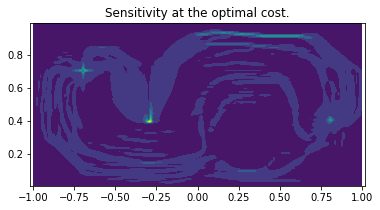

In [75]:
fig = plt.figure(figsize=[6,3]); plt.title('Sensitivity at the optimal cost.'); plt.axis('equal'); 
plt.contourf(X,Y,func_deriv(res.x).reshape(hfmShape));
savefig(fig,'OptimalSensitivity.png')

In [76]:
optInput['tips']=optInput['inspectSensitivity']
optInput['exportValues']=1
optOutput = HFMUtils.Run(optInput)

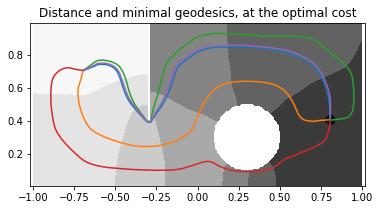

In [77]:
fig = plt.figure(figsize=[6,3]); plt.title('Distance and minimal geodesics, at the optimal cost'); plt.axis('equal'); 
for geo in HFMUtils.GetGeodesics(optOutput): plt.plot(geo[:,0],geo[:,1]) 
plt.contourf(X,Y,optOutput['values'],cmap='Greys');
savefig(fig,'OptimalPathCost.png')

## 6. Sensitivity at multiple points, possibly weighted

The HFM library lets you compute the sensitivity at multiple points, possibly weighted. 
For instance, assume $u : \Omega \to R$ is a distance map computed using the fast marching algorithm. 
Let also $x_0,x_1,x_2 \in \Omega$ and $\alpha_0,\alpha_1,\alpha_2 \in R$. We show how to compute the sensitivity of the the vector
$$
    (\alpha_0 u(x_0)+\alpha_1 u(x_1),\ \alpha_2 u(x_2))
$$
w.r.t. variations of the cost function.

### 6.1 Raw arguments

In [78]:
# Define the problem
hfmIn = {
    'model':'Isotropic2',
    'cost':1.,
    'seeds':[[0.,0.]],
    'exportValues':1.,
    'arrayOrdering':'RowMajor'
}
hfmIn.update(HFMUtils.Rect(sides=[[-1.,1.],[-1.,1.]],dimx=100))
X = np.array(HFMUtils.GetGrid(hfmIn))

In [79]:
# Where to get the sensitivity
x0,x1,x2 = [0.1,-0.4],[0.5,0.8],[-0.5,-0.7] 
alpha0,alpha1,alpha2 = 2.,3.,4.5 

# Format this data for the input
hfmIn['inspectSensitivity'] = [x0,x1,x2] 
hfmIn['inspectSensitivityWeights'] = [alpha0,alpha1,alpha2]

# How to group the points (here the first two are summed together, and the last one is alone)
hfmIn['inspectSensitivityLengths'] = [2.,1.]

In [80]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.00234 s.
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


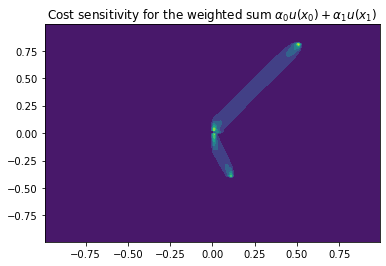

In [81]:
plt.title(r"Cost sensitivity for the weighted sum $\alpha_0 u(x_0)+\alpha_1 u(x_1)$")
plt.contourf(*X,hfmOut['costSensitivity_0']);

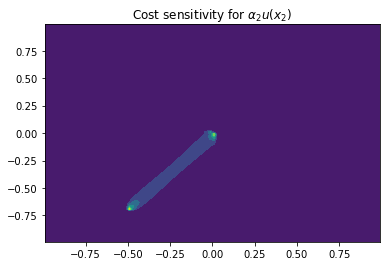

In [82]:
plt.title(r"Cost sensitivity for $\alpha_2 u(x_2)$")
plt.contourf(*X,hfmOut['costSensitivity_1']);

### 6.2 Using automatic differentiation 

The reverse AD library currently only supports scalar valued objectives. In the case of a non-scalar output, multiple calls to the gradient are required. The cost remains reasonable provided the adequate data is cached in the forward pass.

In [83]:
hfmIn_ad = {key:hfmIn[key] for key in ['model','seeds','arrayOrdering','dims','origin','gridScale']}
hfmIn_ad['extractValues']=True

In [84]:
shape = hfmIn_ad['dims'].astype(int)
cost = np.ones( shape ) 

rev, cost_ad = ad.Reverse.empty(inputs = cost, input_iterables = (dict,))
hfmIn_ad['cost'] = cost_ad

We provide an un-named cache variable, which will be saved by the Reverse AD structure, like the other input arguments.

In [85]:
hfmOut_ad,values_ad = rev.apply(HFMUtils.RunSmart, hfmIn_ad, cache=HFMUtils.Cache() )

Requesting cacheable data
Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.00238 s.
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Filling cache data


In [86]:
values_ad_interp = fd.UniformGridInterpolator(X,values_ad)
objective = ad.array( (alpha0*values_ad_interp(*x0) + alpha1*values_ad_interp(*x1), alpha2*values_ad_interp(*x2)) )

We defined a multi-dimensional objective function, but we can only request its gradient component by component so far. The cost remains bearable since the fast marching solver is bypassed thanks to cached data.

In [87]:
grad_0, = rev.to_inputshapes(rev.gradient(objective[0]))
print("------")
grad_1, = rev.to_inputshapes(rev.gradient(objective[1]))

Providing cached data
Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Bypassing fast marching solver based on cached data.
Field exportActiveOffsets defaults to 0
------
Providing cached data
Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Bypassing fast marching solver based on cached data.
Field exportActiveOffsets defaults to 0


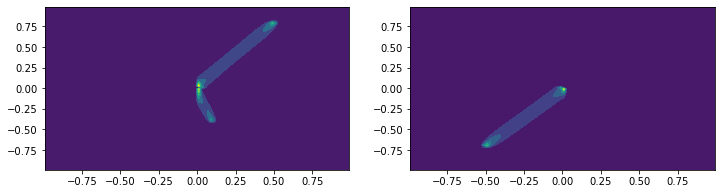

In [88]:
plt.figure(figsize=[12,3])
plt.subplot(1,2,1)
plt.contourf(*X,grad_0)
plt.subplot(1,2,2)
plt.contourf(*X,grad_1);

## 7. Sensitivity to multiple parameters

In this experiment, we consider a metric depending on two cost functions, and perform sensitivity analysis w.r.t. each both. More precisely, we use the two dimensional diagonal metric model, which lets the user choose different costs of motion along the $x$ and $y$ axes, and independent perturbations.

See the next [notebook](SensitivitySL) for more advanced examples in the same vein, featuring non-axis aligned metrics of Riemannian or Finslerian class. 

<!---This model admits a differentiable variant, similarly to the isotropic case, although it is not implemented at the time of writing.--->

In [89]:
hfmInput2 = {'model':'Diagonal2'}

In [90]:
# Possibly distinct cost, and scale, in the x and y directions
cost = hfmInput['cost']; gridScale= hfmInput['gridScale'];
hfmInput2['cost'] = np.stack((cost, cost),axis=2)
hfmInput2['gridScales'] = [gridScale, gridScale]

for key in ['walls','dims','seeds','tips','seedValues','arrayOrdering','exportValues','origin','inspectSensitivity']:
    hfmInput2[key]=hfmInput[key]

In [91]:
hfmOutput = HFMUtils.Run(hfmInput) # Isotropic model
print("---")
hfmOutput2 = HFMUtils.Run(hfmInput2) # Diagonal model

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.004782 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
---
Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.004783 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


In order to make a consistency check, the diagonal matrix was set up to reproduce exactly the isotropic cost, by choosing identical diagonal coefficients.

In [92]:
# Arrival time values are equal by construction of the test cases
walls,values,values2 = hfmInput['walls'],hfmOutput['values'].copy(),hfmOutput2['values'].copy()
values[walls]=0; values2[walls]=0; # Values equal inf on the walls.
np.max(np.abs(values-values2))

0.0

We first discuss backward differentiation. As can be observed, the sensitivity of the arrival time w.r.t. variations of the cost associated with the x and y directions are now returned separately.

In [93]:
sensitivity2 = hfmOutput2['costSensitivity_0'] # Sensitivity of the arrival time at the first point

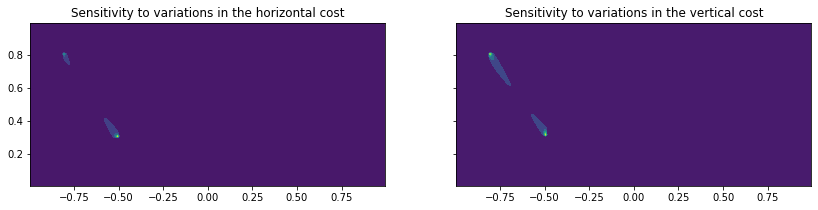

In [94]:
_, (ax0,ax1) = plt.subplots(1,2,sharey=True,figsize=(14,3));
X=np.array(HFMUtils.GetGrid(hfmInput))
# Display sensitivity w.r.t variations of the first component of the cost, relative to the x direction
ax0.set_title('Sensitivity to variations in the horizontal cost')
ax0.contourf(*X,sensitivity2[:,:,0]) 
ax1.set_title('Sensitivity to variations in the vertical cost')
ax1.contourf(*X,sensitivity2[:,:,1]);

Consistency check with the isotropic case. Since we choose a diagonal model with equal costs along the two axes, we fall back to the sensitivity of the isotropic model by adding the two sensitivities of the diagonal model.

In [95]:
np.max(np.abs(sensitivity2.sum(axis=2)-hfmOutput['costSensitivity_0']))

8.673617379884035e-19

We next turn to forward differentiation. We may specify distinct variations for the two components of the cost, here associated with the and X,Y axes. 

In [100]:
hfmInput2['costVariation'] = np.stack([ np.stack( (X[0]+X[1]**2, cost,    0.*cost), axis=2),  
                                        np.stack( (X[1]-X[0],    0.*cost, cost),    axis=2)] ,3)
hfmInput2['seedValueVariation']=[[0,0],[0,0],hfmInput['seedValues']] # Above named zeta.

In [101]:
hfmOutput2 = HFMUtils.Run(hfmInput2) 

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.005031 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


In [102]:
hfmInput2['costVariation'][:,:,0,:].shape

(200, 100, 2)

Consistency check with sensitivity analyis.

In [106]:
assert np.abs((hfmInput2['costVariation'][:,:,0,:]*hfmOutput2['costSensitivity_1']).sum()  
    - hfmOutput2['valueVariation'][index1[0],index1[1],0] ) < 1e-16

Consistency check based on Euler's identity for homogeneous functions.

In [107]:
assert np.max(np.abs(hfmOutput2['valueVariation'][:,:,1]+hfmOutput2['valueVariation'][:,:,2]-values)) < 1e-14